# Computing saliency masks with the PAIRML saliency library

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the Inception V3 convolutional neural network. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   Occlusion

This notebook assumes you have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency
```

In [131]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from PIL import ImageDraw
from matplotlib import pylab as P
import pickle
import random
import os
slim=tf.contrib.slim

if not os.path.exists('models/research/slim'):
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/research/slim')
from nets import inception_v3
os.chdir(old_cwd)

# From our repository.
import saliency

%matplotlib inline

### Utility methods

In [132]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def resize(img, size):
  im = img.resize((size, size))
  im = np.asarray(im)[:, :, :3]
  return im / 127.5 - 1.0

def drawPath(img, list_of_points, color, visuals=True):
    '''mark original maze with path or with salient points'''
    maze_original_edited = np.copy(img)
    for i, point in enumerate(list_of_points):
        x,y = point
        maze_original_edited[x,y] = color 
    if visuals:
        ShowImage(maze_original_edited)
    return maze_original_edited
 

### Maze generator code
Run the following cell to generate a new bmp of a new cell 32x32 in size.

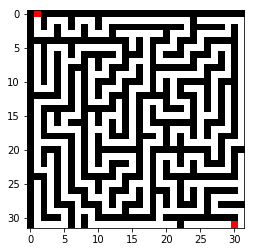

In [133]:

def update_pos(direct, x, y):
    if direct == 0:
        return (x+1,y)
    elif direct == 1:
        return (x, y+1)
    elif direct == 2:
        return (x-1, y)
    else:
        return (x, y - 1)


def carve(maze, x, y):
    direction = random.randint(0,4)
    count = 0
    while count < 4:
        (x1, y1) = update_pos(direction, x, y)
        (x2, y2) = update_pos(direction, x1, y1)
        if x2 > 0 and x2 < width and y2 > 0 and y2 < height:
            if maze[y1,x1] == 1 and maze[y2,x2] == 1:
                maze[y1, x1] = 0
                maze[y2, x2] = 0
                carve(maze, x2, y2)
        count = count + 1
        direction = (direction + 1) % 4

def writeImage(a):
    out = PIL.Image.new('RGB', a.shape, (255,255,255))
    d = ImageDraw.Draw(out)

    (height, width) = a.shape
    for x in range(height):
        for y in range(width):
            if a[y,x] == 0:
                d.point([x,y], fill=(255,255,255))
            else:
                d.point([x,y], fill=(0,0,0))
    d.point([1,0], fill=(255,0,0))
    d.point([width - 2, height - 1], fill=(255,0,0))
    return out

def generate(width, height):
    if width < 2 or height < 2:
        raise "Maze needs to be at least 2x2"
    maze = np.ones((height,width))
    maze[1, 1] = 0
    carve(maze, 1,1)
    maze[0,1] = 0 
    maze[height - 1, width - 2] = 0
    return maze

maze = generate(32, 32)
out = writeImage(maze)
P.imshow(out)


### Loading the Inception model graph

Run the following cell to download the network. Alternatively, the pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the tensorflow_inception_graph.pb file from the archive and set its path to model_fn variable.

In [134]:
# Use either wget or curl depending on your OS.
if not os.path.exists('inception_v3.ckpt'):
  #!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !curl -O http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !tar -xvzf inception_v3_2016_08_28.tar.gz

ckpt_file = './inception_v3.ckpt'

### Adding a single logit tensor for which we want to compute the mask

In [135]:
graph = tf.Graph()

with graph.as_default():
  images = tf.placeholder(tf.float32, shape=(None, 320, 320, 3))

  with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_file)
    
  # Construct the scalar neuron tensor.
  logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[0][neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits, 1)


INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


Prediction class for maze: 905


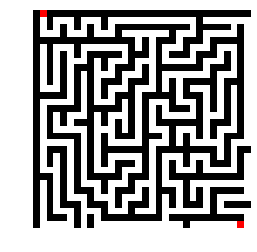

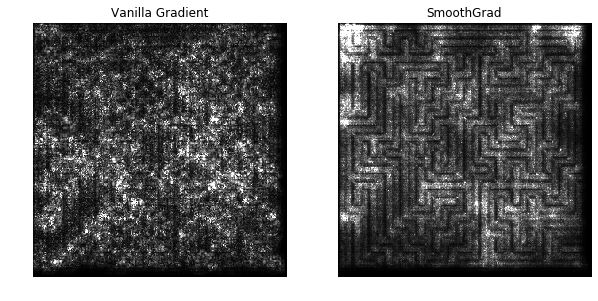

In [136]:
# Load the image
mazeimg = resize(out, 320)

# Show the image
ShowImage(mazeimg)

# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

prediction_class = sess.run(prediction, feed_dict = {images: [mazeimg]})[0]
print("Prediction class for maze:", prediction_class)
# Compute the vanilla mask and the smoothed mask.
#vanilla_mask_3d = gradient_saliency.GetMask(maze, feed_dict = {neuron_selector: prediction_class})
#smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(maze, feed_dict = {neuron_selector: prediction_class})
vanilla_mask_3d = gradient_saliency.GetMask(mazeimg, feed_dict = {neuron_selector: prediction_class})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(mazeimg, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

### Vanilla Gradient & SmoothGrad

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


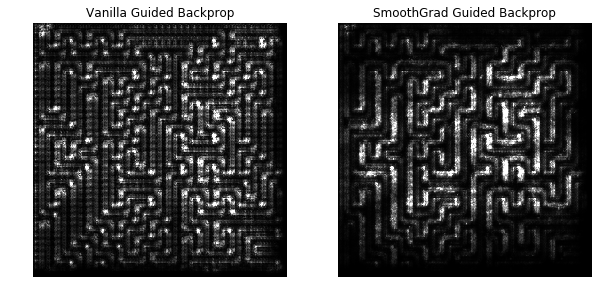

In [137]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!
guided_backprop = saliency.GuidedBackprop(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
    mazeimg, feed_dict = {neuron_selector: prediction_class})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
    mazeimg, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))

## Integrated Gradients & SmoothGrad

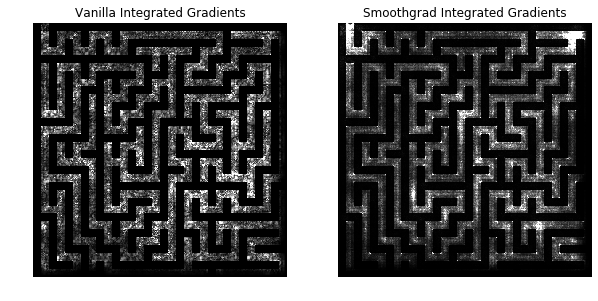

In [138]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients(graph, sess, y, images)

# Baseline is a black image.
baseline = np.zeros(mazeimg.shape)
baseline.fill(-1)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  mazeimg, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  mazeimg, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

# Find most salient point in original maze 

[[1, 29], [1, 30], [2, 29]] most salient points in actual maze: 


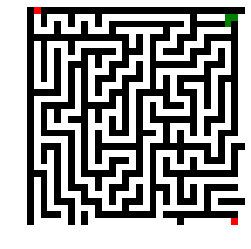

In [146]:
import numpy as np

def order_saliency(maze_salient, d):
    X, Y = maze_salient.shape
    sum_list = []
    sumIdx_list = []
    idx = 0
 
    for i in range(X-d):
        for j in range(Y-d):
            sum_list.append((np.sum(salient[i:i+d,j:j+d]),idx))
            idx += 1
            sumIdx_list.append((i,j))
    sumIdx_list = np.array(sumIdx_list)
    sum_list = np.array(sum_list)
 
    sum_list = sum_list[sum_list[:,0].argsort()]
    sum_list = sum_list[::-1] 
    
    max_indx = []
    for i in sum_list[:,1]:
        max_indx.append(sumIdx_list[int(i)])
    max_indx = np.stack(max_indx, axis=0 )
 
    return sum_list[:,0], max_indx
 
'''map to actual picture 32x32'''
def map2actual(maze_salient, maze_original, d, k, unique=True):
    maze_original=maze_original.astype(int)
 
    sum_list, max_indx = order_saliency(maze_salient,d)
    max_indx_actual = (np.around(max_indx, decimals=-1)/float(d)).astype(int)
    
    if unique:
        indexes = np.unique(max_indx_actual, return_index=True, axis=0)[1]
        max_indx_actual = np.stack([max_indx_actual[index] for index in sorted(indexes)])
    k_max_indx_actual = max_indx_actual[:k]
        
    salient_points_original = [None]*k
    for i, salient_point in enumerate(k_max_indx_actual):
        x,y = salient_point
#         if np.all(maze_original[x,y]!=1):
#             r = np.copy([x,y])
#             l = np.copy([x,y])
#             u = np.copy([x,y])
#             d = np.copy([x,y])
#             pos = [r,l,u,d]
#             counts = np.zeros(len(pos))
#             while np.all(maze_original[r[0],r[1]]!=1) or counts[0]<1 or r[0]>30:
#                 r[0] += 1
#                 counts[0] += 1
#             while np.all(maze_original[l[0],l[1]]!=1) or counts[1]<1 or l[0]<1:
#                 l[0] -= 1
#                 counts[1] += 1
#             while np.all(maze_original[u[0],u[1]]!=1) or counts[2]<1 or u[1]>30:
#                 u[1] += 1
#                 counts[2] += 1
#             while np.all(maze_original[d[0],d[1]]!=1) or counts[3]<1 or d[1]<1:
#                 d[1] -= 1
#                 counts[3] += 1
 
#             min_pos_indx = np.argmin(counts)
#             min_pos = pos[min_pos_indx]
#         else:
        min_pos = [x,y]
        salient_points_original[i] = min_pos
 
    return salient_points_original

salient = smoothgrad_mask_grayscale
salient_points_original = map2actual(salient, resize(out, 32), 10, 3)
maze_with_saliency = drawPath(resize(out, 32), salient_points_original, [-1,0,-1])
print("{} most salient points in actual maze: ".format(salient_points_original))

# Maze Solver

In [150]:
import itertools
from scipy import misc
from scipy.sparse.dok import dok_matrix
from scipy.sparse.csgraph import dijkstra

# Defines a translation from 2 coordinates to a single number
def to_index(y, x):
    return y * img.shape[1] + x


# Defines a reversed translation from index to 2 coordinates
def to_coordinates(index):
    return int(index / img.shape[1]), int(index % img.shape[1])

def get_pred(preds, target, path):
    if target == source:
        return path
    parent = preds[0][target]
    return get_pred(preds, parent, path + [to_coordinates(parent)])

def solve(img):
    # A sparse adjacency matrix.
    # Two pixels are adjacent in the graph if both are painted.
    adjacency = dok_matrix((img.shape[0] * img.shape[1],
                            img.shape[0] * img.shape[1]), dtype=bool)

    # The following lines fills the adjacency matrix by
    #directions = list(itertools.product([0, 1, -1], [0, 1, -1]))
    directions = [(1,0), (0,1), (-1, 0), (0,-1)]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] != 0:
                continue

            for y_diff, x_diff in directions:
                if i + y_diff < img.shape[0] and j + x_diff < img.shape[1] and img[i + y_diff, j + x_diff] == 0:
                    adjacency[to_index(i, j),
                              to_index(i + y_diff, j + x_diff)] = True

    # We chose two arbitrary points, which we know are connected
    source = to_index(0, 1)
    target = to_index(img.shape[0] - 1, img.shape[1] - 2)

    # Compute the shortest path between the source and all other points in the image
    _, preds = dijkstra(adjacency, directed=False, indices=[source],
                           unweighted=True, return_predecessors=True)

    return get_pred(preds, target, [])

solution = solve(maze)



In [ ]:
def check_sol(sol, salient_pts):
    for (xs, ys) in salient_pts:
        for (x,y) in sol:
            if (x == xs and y == ys):
                return True
    return False

def salience(maze, visuals=True):
    k = 3
    d = 10
    out = writeImage(maze)
    mazeimg = resize(out, 320)

    # Run Inception v3 for image classification
    prediction_class = sess.run(prediction, feed_dict = {images: [mazeimg]})[0]

    # Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
    integrated_gradients = saliency.IntegratedGradients(graph, sess, y, images)

    # Baseline is a black image.
    baseline = np.zeros(mazeimg.shape)
    baseline.fill(-1)
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
      mazeimg, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)

    salient = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)
    if visuals:
        ShowGrayscaleImage(salient, title='Smoothgrad Integrated Gradients')
    return map2actual(salient, resize(out, 32), d, k)
    
    
STEPS = 2
mazes = []
good = []

for iteration in range(STEPS):
    # Generate new maze
    maze = generate(32, 32)
    # Get salience points
    salient_pts = salience(maze)
    # Solve
    solution = solve(maze)
    # Compare solutions
    mazeout = drawPath(resize(writeImage(maze),32), solution, [0,1,0], visuals=False)
    mazeout = drawPath(mazeout, salient_pts, [-1,0,-1])
    # Show it
#     P.imshow(mazeout)
    good.append(check_sol(solution, salient_pts))
    mazes.append(maze)

print(good)
# print(check_sol(coords, salient_points_original))

